# Deep Q-learning

In a [previous notebook](./tabular.ipynb), we saw how in small state spaces, simple table-based updates building upon the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) can achieve rapid learning of the optimal $Q$-function. In the present notebook, we consider learning with [Deep Q-Networks (DQN)](https://deepmind.com/research/dqn/) as an alternative for large or continuous state spaces. The crux of the method is to approximate the optimal $Q$-function by an enormously rich function class, namely neural networks.

The presentation in this notebook uses substantial parts of the code from the wonderful [official pytorch tutorial](https://github.com/jmichaux/dqn-pytorch/blob/master/main.py).

## State space

 In order to illustrate the power of DQN, we work in a different state space than in the [CEM example](./cem.ipynb). Indeed, one of the reasons that CEM could excel in solving the cartpole problem so rapidly, was that the compact state space representation featured already highly non-trivial domain knowledge.  Indeed, just looking at the pictures, it takes a moment of thought to realize that the problem is completely specified by four characteristics.

In order to avoid relying on non-trivial domain knowledge, we now work on a much larger state space, consisting of pixel representations. First, we reset the environment and define screen characteristics.

In [1]:
import gym
import numpy as np
env = gym.make('CartPole-v0')
env.reset()

scr_height = 400
scr_width = 600
world_width = env.x_threshold * 2
scale = scr_width / world_width
view_width = int(scr_width * 0.6)

Next, we extract part of the screen centered around the cart.

In [2]:
import torch
import torchvision.transforms as T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_screen():
    screen = env.render(mode = 'rgb_array').transpose((2, 0, 1))
    screen = screen[:, int(scr_height * 0.4):int(scr_height * 0.8)]

    #determine pixel region dependent on cart location
    cart_loc = int(env.state[0] * scale + scr_width / 2.0)
    if cart_loc < view_width // 2:
            slice_range = slice(view_width)
    elif cart_loc > scr_width - view_width // 2:
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_loc - view_width // 2,
                            cart_loc + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
    screen = torch.from_numpy(screen)
    resize = T.Compose([T.ToPILImage(),
                        T.Resize(40, interpolation=Image.CUBIC),
                        T.ToTensor()])
    return resize(screen).unsqueeze(0).to(device)

Let's visualize an example of an extracted screen.

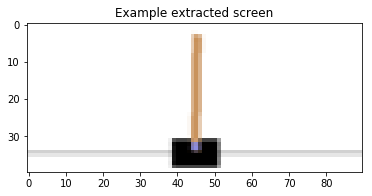

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Policy and Target Networks

In [CEM](./cem.ipynb), we approximated the Q function linearly. This worked nicely, since we relied on a compact representation of the state space as a 4-dimensional vector. Working now directly on pixel space, it seems difficult to estimate the parameters of a linear approximation reasonably well. Therefore, we turn to a more sophisticated function represented by a convolutional neural network.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self,
                h,
                w,
                outputs):
        """Initialize the CNN
    
        # Arguments
            h: image height
            w: image width
            outputs: output size of linear layer
        # Result
            initialized CNN
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, stride = 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5, stride = 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride = 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - kernel_size) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        """Suggest action based on state x
    
        # Arguments
            x: input image describing the state of the environment
        # Result
            suggested action
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

As we discuss below, it will be convenient to create two instances of the network, the **policy network** and the **target network**.

In [40]:
import torch.optim as optim

nactions = env.action_space.n
scr_height_resize = 40
scr_width_resize = 90

policy_net = DQN(scr_height_resize, scr_width_resize, nactions).to(device)
target_net = DQN(scr_height_resize, scr_width_resize, nactions).to(device)

#copy initialization from policy net
target_net.load_state_dict(policy_net.state_dict())
c = target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())

## Replay Memory

In order to carry out the TD learning, we first need to build up a large pool of transition training data consisting of tuples $(s_i, a_i, s_i', r_i)$. They form the **replay memory**.

In [ ]:
import random

mem_size = int(1e4)
memory = []
env.reset()

last_screen = get_screen()
current_screen = get_screen()

for _ in range(mem_size):
    s = current_screen - last_screen    
    
    a = torch.tensor([[random.randrange(nactions)]],
                    device = device,
                    dtype=torch.long)
    _, r, d, _ = env.step(a.item())
    r = torch.tensor([r], device = device)
    
    last_screen = current_screen
    current_screen = get_screen()
    
    if not d:
        ss = current_screen - last_screen
    else:
        ss = None
        env.reset()
    memory += [[s, a, r, ss]]

## The Bellman Equation and Temporal-Difference Learning

Although CEM is an intriguingly simple method that works well for the ``cartpole`` example, it is highly *sample inefficient*. That is, for each parameter value $\theta$, we need to follow an entire episode in order to obtain a single reward value that we can use for fitting. 

Q-learning methods aim to drastically improve sample efficiency by relying on the **Bellman Equation**. Recall that this equation states that the action-value function $Q^*$ associated with an optimal policy satisfies the identity
$$Q^*(s, a) = r + \max_{a' \in A} Q^*(s', a'),$$
where $s'$ is the state of the environment after performing the action $a$ in state $s$. Deep $Q$-learning leverages this identity by choosing $\theta$ to minimize 
$$\ell\big(Q_\theta(s_i, a_i) - ( r_i + \max_{a' \in A} Q_\theta(s'_i, a'))\big)$$
for a suitable loss function $\ell$, where $\{(s_i, a_i, s_i', r_i)\}_i$ are arbitrary samples from the environment. In particular, we are now substantially more sample-efficient as we obtain *one target value per step* instead of *one target value per episode*.

Fitting the parameters $\theta$ via the Bellman equation is also known as **temporal-difference (TD) learning**.

In practice, updating the Q-network through
$$\ell\big(Q_\theta(s_i, a_i) - ( r_i + \max_{a' \in A} Q_\theta(s'_i, a'))\big)$$
creates instabilities since the optimal action is selected with respect to a network whose weights are in the process of being learned. Therefore, we use a **policy network** $Q_\theta$ and a **target network** $Q_{\theta^-}$ and learn the weights of the policy network through  
$$\ell\big(Q_\theta(s_i, a_i) - ( r_i + \max_{a' \in A} Q_{\theta^-}(s'_i, a'))\big).$$
The weights $\theta^-$ of the target network remain stable over several iterations and are only periodically updated with the learned weights from the policy network. In practice, this stabilizes the training process substantially.



In [ ]:
BATCH_SIZE = 128
GAMMA = .99

def optimize_model():
    """Train Q-function approximation by performing gradient descent with data from experience replay
    """

    transitions =  random.sample(memory, BATCH_SIZE)
    # Syntactic sugar to transpose batch transitions
    batch = list(zip(*transitions))

    # Compute mask of non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch[2])), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch[2]
                                                if s is not None])
    s = torch.cat(batch[0])
    a = torch.cat(batch[1])
    r = torch.cat(batch[3])

    #compute q values for selected actions in batch
    q = policy_net(s).gather(1, a)

    # compute state-value function for non-final states through the target net
    v = torch.zeros(BATCH_SIZE, device=device)
    v[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # compute the expected q-values
    expected_q = (v * GAMMA) + r

    # compute Huber loss
    loss = F.smooth_l1_loss(q, expected_q.unsqueeze(1))

    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## $\varepsilon$-Greedy Policy

In the case of a perfectly estimated $Q$-function, when in state $s$, we should always choose an action $a$ solving the maximization problem $\max_a Q^*(s, a).$ However, when $Q^*$ is still being learned, this **greedy policy** results in poor exploration of the state space. Therefore, we pick a random action with a non-zero probability $\varepsilon$, thereby leading to the **$\varepsilon$-greedy policy**. As the learning proceeds and stabilizes $\varepsilon$ decreases gradually in order to give greater weight to the greedy policy.

In [36]:
import math

EPS_START = .9
EPS_END = .05
EPS_DECAY = 200

steps_done = 0

def select_action(s):
    """Select action based on \e-greedy policy
    
    # Arguments
        s: current state
    # Result
        suggested action
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    #policy suggested by policy net
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(s).max(1)[1].view(1, 1)
  
    #random policy
    else:
        return torch.tensor([[random.randrange(nactions)]], 
                            device = device, 
                            dtype = torch.long)


## Main loop

Now, we can assemble all the pieces into a main loop.

In [37]:
from itertools import count
import math
import random
mem_pos = 0

In [ ]:
#frequency of updating target net
TARGET_UPDATE = 10

#number of episodes
neps = int(1e3)

total_reward = 0

for i in range(neps):
    # Initialize the environment and state
    env.reset()
    print('epoch')

    last_screen = get_screen()
    current_screen = get_screen()
    
    for t in count():
        #perform one step in environment
        s = current_screen - last_screen
        a = select_action(s)
        _, r, done, _ = env.step(a.item())
        r = torch.tensor([r], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            ss = current_screen - last_screen
        else:
            ss = None
        if done:
            env.reset()

        #update replay buffer
        memory[mem_pos] = (s, a, ss, r)
        mem_pos = (mem_pos + 1) % mem_size

        # Perform one step of the optimization (on the target network)
        optimize_model()
        s = ss
        if done:   
            total_reward += t
            break
    if i % TARGET_UPDATE == 0:
            print('updating')
            print(total_reward)
            total_reward = 0
            target_net.load_state_dict(policy_net.state_dict())

## Double Deep Q Networks

[Double Deep Q Networks (DDQN)](https://arxiv.org/abs/1509.06461) are a nice trick for stabilizing the learning with respect to the vanilla DQNs.

## Separation of Action Selection and Evaluation

Recall that the idea behind DQN is to cast the approximation of the $Q$ function as a supervised learning problem via the Bellman equation. More precisely, we learn the parameters $\theta$ of the policy network $Q_\theta(s,a)$ by regressing them against the quantities 
$$r + \gamma \max_{a' \in A} Q_{\theta^-}(s', a')$$ 
from the target network $Q_{\theta^-}$, where $s'$ is the state entered from $s$ after performing the action $a$. We note that in the above expression the target network performs two tasks. First, $\max_{a' \in A} Q_{\theta^-}(s', a')$ selects the optimal action $a_{\mathsf{opt}}$ when in state $s'$. Second, the value of performing this action is also estimated through $r + Q_{\theta^-}(s', a_{\mathsf{opt}})$. This entanglement often leads to overestimation of certain $Q$-values, thereby slowing down the learning.

[DDQNs]() counter the overestimation by selecting the action via the policy network while estimating its value via the target network. That is, the targets for $Q$-learning become
$$r + Q_{\theta^-}(s', a_{\mathsf{opt-DDQN}}),$$
where $a_{\mathsf{opt-DDQN}}$ solves the maximization problem $\max_{a' \in A} Q_{\theta}(s', a')$ for the policy network $Q_\theta$.

In [16]:
BATCH_SIZE = 128
GAMMA = .99

def optimize_model():

    transitions =  random.sample(memory, BATCH_SIZE)
    # Syntactic sugar to transpose batch transitions
    batch = list(zip(*transitions))

    # Compute mask of non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch[2])), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch[2]
                                                if s is not None])
    s = torch.cat(batch[0])
    a = torch.cat(batch[1])
    r = torch.cat(batch[3])


    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    v = torch.zeros(BATCH_SIZE, device=device)
    chosen_as = policy_net(non_final_next_states).max(1)[1]
    chosen_as = torch.stack((chosen_as, chosen_as), 1)
    v[non_final_mask] = target_net(non_final_next_states).gather(1, chosen_as)[:, 0].detach()
    
    # compute the expected q-values
    expected_q = (v * GAMMA) + r

    # compute Huber loss
    loss = F.smooth_l1_loss(q, expected_q.unsqueeze(1))

    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()